# Lesson 20 

This lesson is entitled "Mixed Precision" but as usual, other concepts are also covered, for example Style Transfer and the Celluar Neural netorks.


Note that at the beginning of the video he talks about using the collation function instead of the callback to do the noisify step, however, this was a bit of a distraction.

## Mixed precision and Accelerator  

This is done at the end of `notebook_17_DDPM_v2.ipynb`  and I decided *not* to repeat it here. This requires some cuda specific details.  He defines a new callback called `MixedPrecision` which is a TrainCB subclass.  It allows you to train at a lower ( 16 bit precision) with increased batched size and higher learning rate. I could not really follow the details.

Hugging face has a library for doing this as well called Accelerator.  One of the features (among other things) is mixed precision training. So he also defined a callback that uses this as well. See the notebook for details, but to be honest the video just flys through this and it is not that clear to me. It is good to know about this though.


## Note on number of inputs to a model

He observes taht learner.py does allow already more then one input, and that can be used to simpllify things a bit. 

## Trick.... 

```python
class MultDL:
    def __init__(self, dl, mult=2): self.dl,self.mult = dl,mult
    def __len__(self): return len(self.dl)*self.mult
    def __iter__(self):
        for o in self.dl:
            for i in range(self.mult): yield o
```

This is a trick to increase the batch size by a factor of 2 to take full advantage of multiple GPUs (As on kaggle).  Why does this work? I am not sure but I suspect that after the cpu has done the processing to create `o` (the batch) we can quickly feed it twice to two different GPUs.   (Otherwise the second GPU would be waiting around for the next batch to be created). 


## Style Transfer

Video at : 20:30 . Notebook 16A_Style_Transfer.ipynb

Idea is to create a combination of two images, the style of one layed onto the content of another. 

In [2]:
import pickle,gzip,math,os,time,shutil,torch,random,timm,torchvision,io,PIL
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torchvision import transforms
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder
from fastcore.foundation import L, store_attr

from minai.datasets import *
from minai.conv import *
from minai.learner import *
from minai.activations import *
from minai.init import *
from minai.sgd import *
from minai.resnet import *

In [3]:
# Image URLs for demos. Change as desired.
face_url = "https://images.pexels.com/photos/2690323/pexels-photo-2690323.jpeg?w=256"
spiderweb_url = "https://images.pexels.com/photos/34225/spider-web-with-water-beads-network-dewdrop.jpg?w=256"

In [5]:
def download_image(url):
    imgb = fc.urlread(url, decode=False) 
    return torchvision.io.decode_image(tensor(list(imgb), dtype=torch.uint8)).float()/255.

content_im.shape: torch.Size([3, 256, 256])


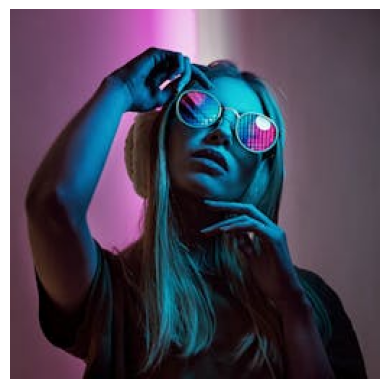

In [6]:
content_im = download_image(face_url).to(def_device)
print('content_im.shape:', content_im.shape)
show_image(content_im);

First step is to try to train a noisy image to match this image.

In [ ]:
# Fake up a date set that is just 0,0 (input target) because we will be training the input image. THis just makes the model look like what the 
# Learner expects.
class LengthDataset():
    def __init__(self, length=1): self.length=length
    def __len__(self): return self.length
    def __getitem__(self, idx): return 0,0

def get_dummy_dls(length=100):
    return DataLoaders(DataLoader(LengthDataset(length), batch_size=1), # Train
                       DataLoader(LengthDataset(1), batch_size=1))      # Valid (length 1)

class TensorModel(nn.Module):
    def __init__(self, t):
        super().__init__()
        self.t = nn.Parameter(t.clone())
    def forward(self, x=0): return self.t

class ImageOptCB(TrainCB):
    def predict(self, learn): learn.preds = learn.model()
    def get_loss(self, learn): learn.loss = learn.loss_func(learn.preds)

In [8]:
def loss_fn_mse(im):
    return F.mse_loss(im, content_im)

model = TensorModel(torch.rand_like(content_im))
cbs = [ImageOptCB(), ProgressCB(), MetricsCB(), DeviceCB()]
learn = Learner(model, get_dummy_dls(100), loss_fn_mse, 
                lr=1e-2, cbs=cbs, opt_func=torch.optim.Adam)
learn.fit(1)

There is no neural network, we are just passing in a noisy image (or something) and trying to get it to match the target image pixel by pixel. 
This is just trivial but will be built on 

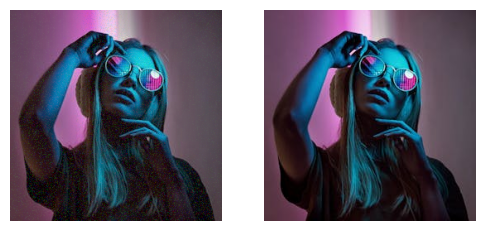

In [9]:
# Result (left) vs target image (right):
show_images([learn.model().clip(0, 1), content_im]);

It will be useful to see how the training progresses from  noise to the image. 

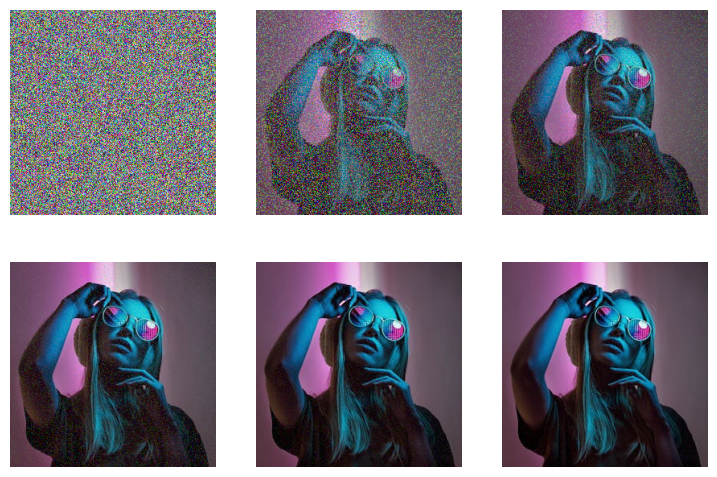

In [11]:
## save images  after every 10 steps (by default)
class ImageLogCB(Callback):
    order = ProgressCB.order + 1
    def __init__(self, log_every=10): store_attr(); self.images=[]; self.i=0
    def after_batch(self, learn): 
        if self.i%self.log_every == 0: self.images.append(to_cpu(learn.preds.clip(0, 1)))
        self.i += 1
    def after_fit(self, learn): show_images(self.images)
    
model = TensorModel(torch.rand_like(content_im))
learn = Learner(model, get_dummy_dls(150), loss_fn_mse, 
                lr=1e-2, cbs=cbs, opt_func=torch.optim.Adam)
learn.fit(1, cbs=[ImageLogCB(30)])

### Extracting features from a pre-trained network

* The video looks at VGG16 network that has been trained on ImageNet (1000 categories).  It is a CNN with max pooling and flattening at the last layers.

* The ealier layers are looking at edges and textures, the later layers are looking at more complex features. (see [Feature Visualization](https://distill.pub/2017/feature-visualization/))  . The earlier layers might be more useful for style transfer.

* This model is available in the `timm` library from fastai. 

In [27]:
print(timm.list_models('*vgg*'))

['repvgg_a0', 'repvgg_a1', 'repvgg_a2', 'repvgg_b0', 'repvgg_b1', 'repvgg_b1g4', 'repvgg_b2', 'repvgg_b2g4', 'repvgg_b3', 'repvgg_b3g4', 'repvgg_d2se', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19', 'vgg19_bn']


In [28]:
vgg16 = timm.create_model('vgg16', pretrained=True).to(def_device).features  # Load pretrained VGG16 model without the classifier head
vgg16

model.safetensors:   0%|          | 0.00/553M [00:00<?, ?B/s]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

### Normalize images 

The model expects images normalized with the same stats as those in the training data.   THese are: 

In [35]:
imagenet_mean = tensor([0.485, 0.456, 0.406])
imagenet_std = tensor([0.229, 0.224, 0.225])

# Where did these come from?
def normalize(im, mean=imagenet_mean, std=imagenet_std): 
     return (im - mean[:,None,None].to(im.device)) / std[:,None,None].to(im.device)

normalize(content_im).mean(dim = (1,2)), normalize(content_im).std(dim = (1,2))

(tensor([-0.9724, -0.9594, -0.4191], device='cuda:0'),
 tensor([0.9319, 0.7640, 0.9817], device='cuda:0'))

In [37]:
# Torchvision has this 
normalize = transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
normalize(content_im).mean(dim = (1,2)), normalize(content_im).std(dim = (1,2))

(tensor([-0.9724, -0.9594, -0.4191], device='cuda:0'),
 tensor([0.9319, 0.7640, 0.9817], device='cuda:0'))

### Ok now we can extract features

In [38]:
def calc_features(imgs, target_layers=(18, 25)): 
    x = normalize(imgs)
    feats = []
    for i, layer in enumerate(vgg16[:max(target_layers)+1]):
        x = layer(x)
        if i in target_layers:
            feats.append(x.clone())
    return feats

### Load in the spider web for experimentation (NOT in the lecture)

In [ ]:
# resize the web image to match the content image
web_im = download_image(spiderweb_url).to(def_device)
resized_web_im = F.interpolate(web_im[None], content_im.shape[-2:], mode='bilinear', align_corners=False)[0]
show_image(resized_web_im);

### Optimizign with Content loss

* To start, we try to optimize an image by comparing its features (from two later layers) with those from the target image.
* This should give us an image that is similar to the target image in structure . 

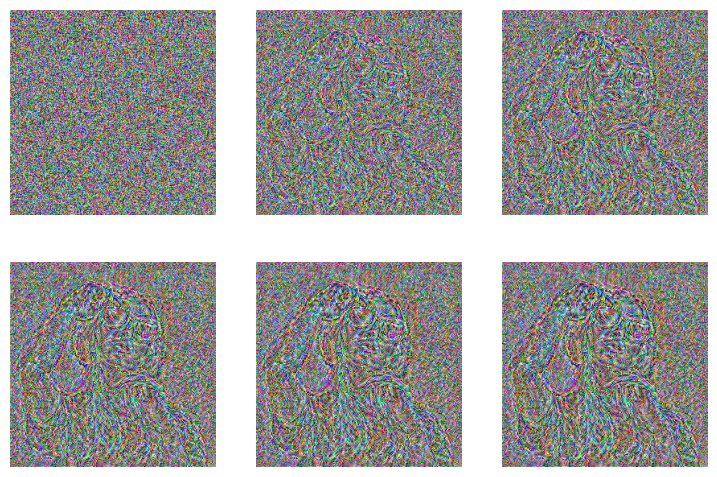

In [42]:
class ContentLossToTarget():
    def __init__(self, target_im, target_layers=(18, 25)):
        fc.store_attr()
        with torch.no_grad():
            self.target_features = calc_features(target_im, target_layers)
    def __call__(self, input_im): 
        return sum((f1-f2).pow(2).mean() for f1, f2 in 
               zip(calc_features(input_im, self.target_layers), self.target_features))
    

loss_function_perceptual = ContentLossToTarget(content_im)
#model = TensorModel(resized_web_im)
model = TensorModel(torch.rand_like(content_im))
learn = Learner(model, get_dummy_dls(150), loss_function_perceptual, 
                lr=1e-2, cbs=cbs, opt_func=torch.optim.Adam)
learn.fit(1, cbs=[ImageLogCB(log_every=30)])

Choosing different layers gets different results

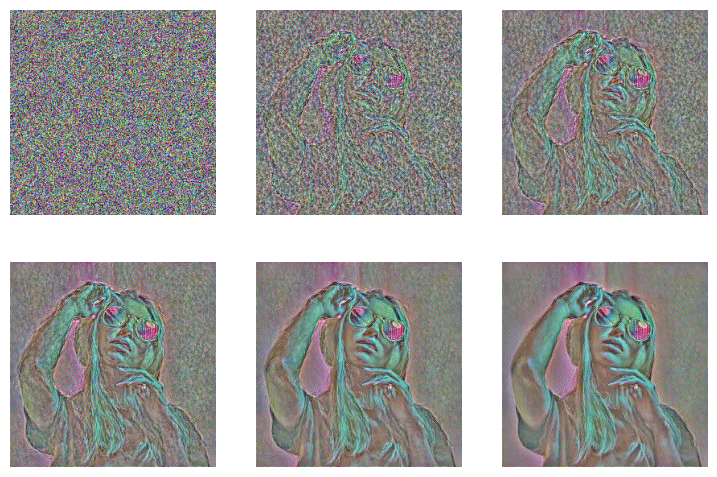

In [43]:
loss_function_perceptual = ContentLossToTarget(content_im, target_layers=(7, 12))
model = TensorModel(torch.rand_like(content_im))
learn = Learner(model, get_dummy_dls(150), loss_function_perceptual, 
                lr=1e-2, cbs=cbs, opt_func=torch.optim.Adam)
learn.fit(1, cbs=[ImageLogCB(log_every=30)])

### Gram matrix style loss

* [A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576) by Gatys et al.

* Problem with content loss is that it is too local.

* Style loss is based on the gram matrix of the features.  

* The gram matrix is the dot product of the features with themselves.  It is a measure of how much the features are correlated with each other.
   - Flatten image so that we have a matrix of features (n_features x n_pixels) 
   - Multiply this by its transpose to get the gram matrix. 
   - This gives a measure of which feature occur together.

* The style loss is the difference between the gram matrix of the target image and the gram matrix of the generated image.

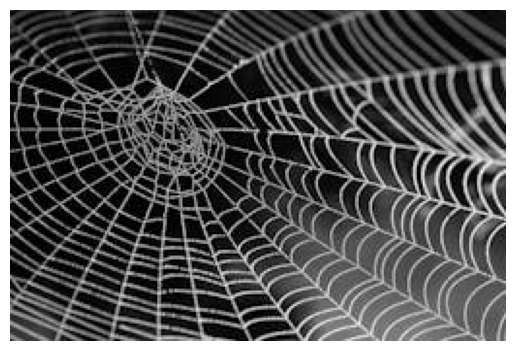

In [44]:
style_im = download_image(spiderweb_url).to(def_device)
show_image(style_im);


In [ ]:
# note the scaling to allow for different image sizes
def calc_grams(img, target_layers=(1, 6, 11, 18, 25)):
    return L(torch.einsum('chw, dhw -> cd', x, x) / (x.shape[-2]*x.shape[-1]) # 'bchw, bdhw -> bcd' if batched
            for x in calc_features(img, target_layers))

style_grams = calc_grams(style_im)

In [46]:
[g.shape for g in style_grams] # The gram matrices for features from different layers

[torch.Size([64, 64]),
 torch.Size([128, 128]),
 torch.Size([256, 256]),
 torch.Size([512, 512]),
 torch.Size([512, 512])]

In [47]:
class StyleLossToTarget():
    def __init__(self, target_im, target_layers=(1, 6, 11, 18, 25)):
        fc.store_attr()
        with torch.no_grad(): self.target_grams = calc_grams(target_im, target_layers)
    def __call__(self, input_im): 
        return sum((f1-f2).pow(2).mean() for f1, f2 in 
               zip(calc_grams(input_im, self.target_layers), self.target_grams))
    
style_loss = StyleLossToTarget(style_im)



### Style transfer

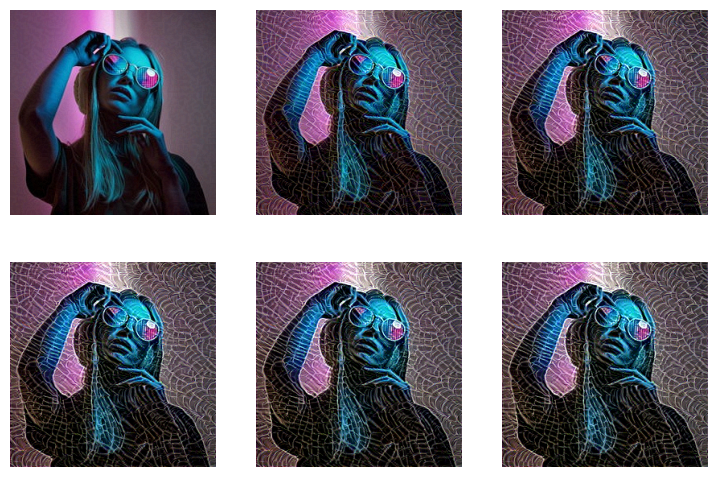

In [52]:
model = TensorModel(content_im) # Start from content image
style_loss = StyleLossToTarget(style_im)
content_loss = ContentLossToTarget(content_im)
def combined_loss(x):
    return style_loss(x) + content_loss(x)
learn = Learner(model, get_dummy_dls(150), combined_loss, lr=1e-2, cbs=cbs, opt_func=torch.optim.Adam)
learn.fit(1, cbs=[ImageLogCB(30)])

### Exxperiments

* Try changing the weights between content and style
* try different layers for content and style
* try different images! ! 
* Try starting from noise or from teh style image.

### NON miniai version 

This seems simpler, but it gets messier when you want to experiment with different options. This is the advantage of a library like miniai

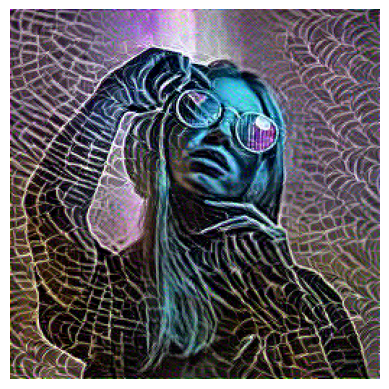

In [60]:
# The image to be optimized
#im = torch.rand(3, 256, 256).to(def_device)
im = content_im.clone().to(def_device)
im.requires_grad = True

# Set up the optimizer
opt = torch.optim.Adam([im], lr=5e-2)

# Define the loss function
style_loss = StyleLossToTarget(style_im)
content_loss = ContentLossToTarget(content_im, target_layers=[6, 18, 25])
def combined_loss(x):
    return 0.5*style_loss(x)  + content_loss(x)

# Optimization loop
for i in range(300):
    loss = combined_loss(im)
    loss.backward()
    opt.step()
    opt.zero_grad()
    
# Show the result
show_image(im.clip(0, 1));

Adding in style loss (from a pre-trained network) can be useful with other deep learning tasks to provide guidance, for example in stable diffusion or other image to image tasks.

## Cellular Neural Network   1:15